# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import TwoChannelCNN, PerceptronReLU
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/inverse_modelling_tfo/tools/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, -1])
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
0,10,-4.999507,1.0,6.0,12.0,0.9,0.11,0.1
1,14,-7.171885,1.0,6.0,12.0,0.9,0.11,0.1
2,19,-9.277114,1.0,6.0,12.0,0.9,0.11,0.1
3,23,-10.143018,1.0,6.0,12.0,0.9,0.11,0.1
4,28,-10.149250,1.0,6.0,12.0,0.9,0.11,0.1


In [3]:
## Create a ratio feature
wave1 = data[data['Wave Int'] == 1.0].reset_index()['Intensity']
wave2 = data[data['Wave Int'] == 2.0].reset_index()['Intensity']
ratio_feature = wave1 - wave2

# Create a new df with only a single set of wave int
data =  data[data['Wave Int'] == 1.0].drop(columns='Wave Int').reset_index()
data['Ratio'] = ratio_feature
# Pivot to bring ratio for all SDD into a column single
data = pd.pivot(data, index=['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"], columns=["SDD"], values="Ratio").reset_index()
data.columns = [str(col) if isinstance(col, int) else col for col in data.columns]

## An alternate to ratio features (Just Intensty, no ratio)
# data = pd.pivot(data, index=['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"], columns=["SDD", "Wave Int"], values="Intensity").reset_index()
# data.columns = ['_'.join([str(col[0]), str(col[1])]) if col[1] != '' else col[0] for col in data.columns]

# NOTE: DO NOT HAVE BOTH running at the same time

In [4]:
# Cleanup
data.dropna(inplace=True)
data.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10,14,19,23,28,...,55,59,64,68,73,77,82,86,91,95
0,2.0,12.0,0.9,0.11,0.100,0.598920,2.158779,4.764065,6.542704,8.031928,...,0.741426,-2.285809,-6.667712,-10.624147,-16.099566,-20.880860,-27.330430,-32.849244,-40.173002,-46.356029
1,2.0,12.0,0.9,0.11,0.225,0.599478,2.163204,4.774771,6.562659,8.069640,...,0.981383,-2.003314,-6.328318,-10.236445,-15.648220,-20.376146,-26.756128,-32.217092,-39.465970,-45.587141
2,2.0,12.0,0.9,0.11,0.350,0.600072,2.167919,4.786194,6.583712,8.108948,...,1.225613,-1.716167,-5.983808,-9.843261,-15.190944,-19.865150,-26.175111,-31.577885,-38.751464,-44.810450
3,2.0,12.0,0.9,0.11,0.475,0.600706,2.172967,4.798451,6.606068,8.150199,...,1.475804,-1.422417,-5.631882,-9.442002,-14.724761,-19.344576,-25.583668,-30.927572,-38.024994,-44.021105
4,2.0,12.0,0.9,0.11,0.600,0.601386,2.178407,4.811696,6.629989,8.193841,...,1.734153,-1.119523,-5.269544,-9.029292,-14.245798,-18.810136,-24.976979,-30.260886,-37.280724,-43.212800


## Creating Features
x_columns will be the input features and y_columns are the target

In [5]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Saturation']
y_columns = ['Fetal Saturation']

## X -> Predictors
# x_columns = list(filter(lambda X: '_' in X, data.columns))
x_columns = list(filter(lambda X: X.isdigit(), data.columns))



## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])
## Manual scale - if needed (With maternal info.)
# data[x_columns[:-2]] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
# data[x_columns[:-2]] += 0.5  # unit var, 0 mean

## Scale non-intensity x columns (Maternal Hb Conc. , Maternal Saturation)
# data["Maternal Saturation"] -= 0.5 
# data["Maternal Hb Concentration"] /= 20
# data["Maternal Hb Concentration"] -= 0.5 


In [6]:
# Print Out Scaler values
print(f'Y scale mean {y_scaler.mean_}')
print(f'Y scale var {y_scaler.var_}')

Y scale mean [0.35]
Y scale var [0.03125]


In [7]:
data[y_columns].value_counts()

Fetal Saturation
-1.414214           375
-0.707107           375
 0.000000           375
 0.707107           375
 1.414214           375
dtype: int64

## Model Configuration

In [8]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)
model_config = {
    'model_class' : TwoChannelCNN,  # Class name
    # 'model_class' : PerceptronReLU,  # Class name
    'model_params' :  [IN_FEATURES, 4, 5, [2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [[IN_FEATURES, 8, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [[IN_FEATURES, 8, 4, OUT_FEATURES]],    # Input params as an array
    'train_split' : 0.8,
}

In [9]:
# Custom Train Function 
def train_model2(iteration_config, epoch=100):
    np.random.seed(70)  # Set seed for consistentcy
    params = {
        'batch_size': iteration_config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
    # model = create_perceptron_model(config['model'])
    # model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    model = model_config['model_class'](*model_config['model_params'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=iteration_config["lr"], momentum=iteration_config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [10]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([32, 16, 8]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.9, 0.95, 0.99]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=50, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=100, resources_per_trial={"cpu": 4, "gpu": 0.05},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


2023-07-04 12:19:05,606	INFO worker.py:1625 -- Started a local Ray instance.
2023-07-04 12:19:06,303	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


== Status ==
Current time: 2023-07-04 12:19:06 (running for 00:00:00.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 4.0/64 CPUs, 0.05/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-04_12-19-06
Number of trials: 70/100 (69 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |
|--------------------------+----------+-----------------------+--------------+-------------+------------|
| train_model2_a4dcd_00000 | RUNNING  | 169.237.32.34:2931672 |           32 | 0.000111295 |       0.99 |
| train_model2_a4dcd_00001 | PENDING  |                       |           16 | 3.88072e-05 |       0.95 |
| train_model2_a4dcd_00002 | PENDING  |                       |         

Trial name,combined_loss,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model2_a4dcd_00000,0.997411,2023-07-04_12-19-16,False,blueberry,9,169.237.32.34,2931672,8.13696,1.00435,8.13696,1688498356,1.00054,9,a4dcd_00000,0.996868
train_model2_a4dcd_00001,1.07794,2023-07-04_12-19-18,True,blueberry,5,169.237.32.34,2931755,9.18481,1.08236,9.18481,1688498358,1.08142,5,a4dcd_00001,0.996783
train_model2_a4dcd_00002,1.73319,2023-07-04_12-19-13,False,blueberry,1,169.237.32.34,2931757,4.47253,4.47253,4.47253,1688498353,1.34226,1,a4dcd_00002,1.29125
train_model2_a4dcd_00003,1.02841,2023-07-04_12-19-18,True,blueberry,5,169.237.32.34,2931759,8.69022,1.1309,8.69022,1688498358,1.01785,5,a4dcd_00003,1.01037
train_model2_a4dcd_00004,0.999577,2023-07-04_12-19-19,False,blueberry,5,169.237.32.34,2931763,10.2667,1.41812,10.2667,1688498359,1.00006,5,a4dcd_00004,0.999519
train_model2_a4dcd_00005,1.0028,2023-07-04_12-19-18,False,blueberry,6,169.237.32.34,2931766,9.51015,0.926411,9.51015,1688498358,1.00127,6,a4dcd_00005,1.00153
train_model2_a4dcd_00006,1.49183,2023-07-04_12-19-14,False,blueberry,1,169.237.32.34,2931771,5.23503,5.23503,5.23503,1688498354,1.27587,1,a4dcd_00006,1.16926
train_model2_a4dcd_00007,1.00824,2023-07-04_12-19-19,False,blueberry,7,169.237.32.34,2931777,9.80352,0.867487,9.80352,1688498359,0.999698,7,a4dcd_00007,1.00854
train_model2_a4dcd_00008,1.11975,2023-07-04_12-19-14,False,blueberry,1,169.237.32.34,2931780,5.11567,5.11567,5.11567,1688498354,1.05804,1,a4dcd_00008,1.05832
train_model2_a4dcd_00009,1.03824,2023-07-04_12-19-14,False,blueberry,1,169.237.32.34,2931782,4.95957,4.95957,4.95957,1688498354,1.01664,1,a4dcd_00009,1.02125


== Status ==
Current time: 2023-07-04 12:19:11 (running for 00:00:05.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-04_12-19-06
Number of trials: 86/100 (70 PENDING, 16 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_a4dcd_00000 | RUNNING  | 169.237.32.34:2931672

2023-07-04 12:19:19,728	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2023-07-04 12:19:19 (running for 00:00:13.43)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0003335084687643 | Iter 5.000: -1.0038184127675167
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-04_12-19-06
Number of trials: 90/100 (70 PENDING, 16 RUNNING, 4 TERMINATED)
+--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_mod

2023-07-04 12:19:23,277	ERROR tune.py:941 -- Trials did not complete: [train_model2_a4dcd_00000, train_model2_a4dcd_00002, train_model2_a4dcd_00004, train_model2_a4dcd_00005, train_model2_a4dcd_00006, train_model2_a4dcd_00007, train_model2_a4dcd_00008, train_model2_a4dcd_00009, train_model2_a4dcd_00011, train_model2_a4dcd_00012, train_model2_a4dcd_00013, train_model2_a4dcd_00014, train_model2_a4dcd_00016, train_model2_a4dcd_00017, train_model2_a4dcd_00018, train_model2_a4dcd_00019, train_model2_a4dcd_00020, train_model2_a4dcd_00021, train_model2_a4dcd_00022, train_model2_a4dcd_00023, train_model2_a4dcd_00024, train_model2_a4dcd_00025, train_model2_a4dcd_00026, train_model2_a4dcd_00027, train_model2_a4dcd_00028, train_model2_a4dcd_00029, train_model2_a4dcd_00030, train_model2_a4dcd_00031, train_model2_a4dcd_00032, train_model2_a4dcd_00033, train_model2_a4dcd_00034, train_model2_a4dcd_00035, train_model2_a4dcd_00036, train_model2_a4dcd_00037, train_model2_a4dcd_00038, train_model2_a4dcd_

Best trial config: {'lr': 4.572406646517584e-05, 'batch_size': 8, 'momentum': 0.95}
Best trial final validation loss: 0.9995194400878663
Best trial final train loss: 1.0000580316211314


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [ ]:
best_trial.config

{'lr': 0.0009986543932824449, 'batch_size': 8, 'momentum': 0.95}

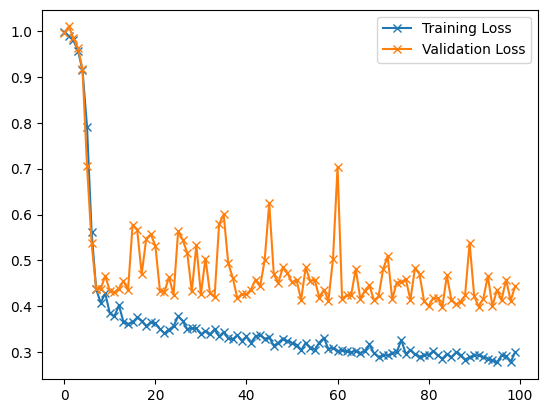

In [ ]:
# Train Model with the given params.
np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': best_trial.config['batch_size'], 'shuffle': True, 'num_workers': 2
}
# params['batch_size'] = 32
train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
model = model_config['model_class'](*model_config['model_params'])
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
# optimizer = SGD(model.parameters(), lr=0.00053, momentum=0.99)
optimizer = SGD(model.parameters(), lr=best_trial.config['lr'], momentum=best_trial.config['momentum'])
# CUDA_VISIBLE is already set to only see one GPU
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=100, gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

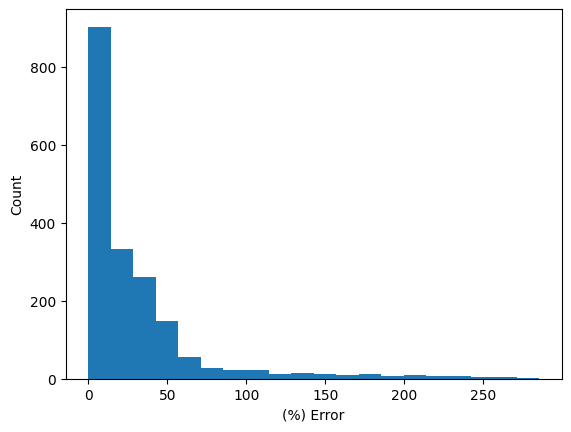

In [ ]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
plt.figure()
error_df['%tage'].plot.hist(bins=20)
plt.xlabel('(%) Error')
plt.ylabel('Count')
plt.show()

In [ ]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]
combined_table = data.join(error_df)
with pd.option_context("display.max_rows", None):
    display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Truth,Predicted,Absolute Error,%tage
1754,6.0,0.16,0.900,0.110,1.414214,0.600,0.216687,0.383313,63.885563
1629,6.0,0.15,0.900,0.110,1.414214,0.600,0.240602,0.359398,59.899589
1779,6.0,0.16,0.925,0.110,1.414214,0.600,0.242597,0.357403,59.567095
1504,6.0,0.14,0.900,0.110,1.414214,0.600,0.264619,0.335381,55.896914
1654,6.0,0.15,0.925,0.110,1.414214,0.600,0.264978,0.335022,55.837031
1804,6.0,0.16,0.950,0.110,1.414214,0.600,0.268582,0.331418,55.236355
1753,6.0,0.16,0.900,0.110,0.707107,0.475,0.155955,0.319045,67.167324
1759,6.0,0.16,0.900,0.125,1.414214,0.600,0.283954,0.316046,52.674374
1529,6.0,0.14,0.925,0.110,1.414214,0.600,0.287448,0.312552,52.092022
1379,6.0,0.13,0.900,0.110,1.414214,0.600,0.288736,0.311264,51.877380


In [ ]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.03128967]
Validation Error(non-normalized): [0.03115995]


In [ ]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
TwoChannelCNN                            --
├─Conv1d: 1-1                            24
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       50
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       3
│    └─Flatten: 2-4                      --
Total params: 77
Trainable params: 77
Non-trainable params: 0

In [ ]:
error_df.columns

Index(['Truth', 'Predicted', 'Absolute Error', '%tage'], dtype='object')